# Costruzione e comparazione di modelli per la predizione del diabete negli stadi iniziali

Progetto per l'esame di Ingegneria della Conoscenza (Corso di Laurea in Informatica, Università di Bari) a cura di Pompeo Francesco Lippolis (mat. 597996).

## Indice
1. [Introduzione](#1.-Introduzione)
1. [Fase preparatoria](#2.-Fase-preparatoria)
1. [Preparazione del Dataset](#3.-Preparazione-del-Dataset)
1. [Training dei modelli](#4.-Training-dei-modelli)
    * [Regressione Lineare](#4.1-Regressione-Lineare)
    * [Regressione Logistica](#4.2-Regressione-Logistica)
    * [Albero Decisionale](#4.3-Albero-Decisionale)
    * [Rete Neurale](#4.4-Rete-Neurale)
    * [Support Vector Machine](#4.5-Support-Vector-Machine)
    * [Random Forest](#4.6-Random-Forest)
    * [ADAptive BOOSTing](#4.7-ADAptive-BOOSTing)
    * [K-Nearest Neighbors](#4.8-K-Nearest-Neighbors)
    * [Naive Bayes](#4.9-Naive-Bayes)
1. [Conclusione](#5.-Conclusione)

## 1. Introduzione
La capacità di predire correttamente l'insorgere del diabete senza fare esami invasivi è utile nell'individuazione precoce della malattia, prima che essa possa arrecare danni al paziente.  
In questo progetto si cerca di trovare il modello più accurato a questo compito, a partire [dal dataset](https://archive.ics.uci.edu/ml/datasets/Early+stage+diabetes+risk+prediction+dataset.) scaricabile dal [Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) dell'[Università della California, Irvine](https://uci.edu/)

## 2. Fase preparatoria

Prima di iniziare vanno caricate tutte le librerie e i componenti esterni necessari al progetto.  
Vengono inoltre impostate le variabili necessarie a rendere l'esperimento riproducibile.

In [1]:
%env PYTHONHASHSEED=1
random_state = 10
import pandas as pd
import numpy as np
np.random.seed(random_state) # NumPy
import random
random.seed(random_state) # Python
import matplotlib.pyplot as plt
%matplotlib inline
import scikitplot as skp
import IPython

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn import metrics

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

from tensorflow import keras
from kerastuner import HyperModel, RandomSearch
from tensorflow import random
random.set_seed(random_state)

import pickle
import os

print("Librerie caricate con successo")

env: PYTHONHASHSEED=1
Librerie caricate con successo


Viene definita la seguente funzione che raccoglie determinate metriche per ogni modello: accuratezza sul training set, accuratezza sul test set, precisione e richiamo.
La funzione, inoltre, produce due grafici: la matrice di confusione per le predizioni fatte sul test set e la curva di precision-recall.

Le matrici di confusione saranno in questa forma:  
![](./Immagini/Matrice_confusione.png)

Le metriche raccolte corrispondono alle seguenti equazioni:

\begin{align}

accuracy & = \frac{tp + tn}{tp + tn + fp + fn} \\
precision & = \frac{tp}{tp + fp} \\
recall & = \frac{tp}{tp + fn} \\

\end{align}

L'accuratezza indica la percentuale di predizioni corrette effettuate.  
La precisione indica, su tutte le predizioni positive, quante sono corrette.  
Il richiamo indica, su tutti gli esempi positivi, quanti sono stati categorizzati correttamente.

In [2]:
def compute_metrics(model, name, train, test, target, target_test):
    prediction_training = model.predict(train).round().astype(int)
    prediction_test = model.predict(test).round().astype(int)

    cm = metrics.confusion_matrix(target_test, prediction_test)
    skp.metrics.plot_confusion_matrix(target_test, prediction_test, figsize=(10,10))

    precision_curve, recall_curve, _ = metrics.precision_recall_curve(target_test, model.predict(test))
    average_precision = metrics.average_precision_score(target_test, model.predict(test))

    acc_train = round(metrics.accuracy_score(target, prediction_training) * 100, 2)
    acc_test = round(metrics.accuracy_score(target_test, prediction_test) * 100, 2)
    precision = round(metrics.precision_score(target_test, prediction_test) * 100, 2)
    recall = round(metrics.recall_score(target_test, prediction_test) * 100, 2)

    plt.figure(figsize=(10,10))
    plt.step(recall_curve, precision_curve, where='post')
    plt.scatter(recall/100, precision/100)
    plt.annotate(name, (recall/100, precision/100), rotation=30, xytext=(-len(name)*6,-len(name)*3.5), textcoords='offset points')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

    df = pd.DataFrame([[acc_train, acc_test, precision, recall, precision_curve, recall_curve, average_precision]], index=[name],
            columns=["Train accuracy", "Test accuracy", "Precision", "Recall", "Precision curve", "Recall curve", "Average precision"])
    display(df[["Train accuracy", "Test accuracy", "Precision", "Recall"]])
    return df

[Torna all'indice](#Costruzione-e-comparazione-di-modelli-per-la-predizione-del-diabete-negli-stadi-iniziali)

## 3. Preparazione del Dataset

Viene caricato il dataset in memoria, successivamente viene controllato il numero di esempi positivi rispetto a quelli negativi presenti nello stesso.

In [3]:
data = pd.read_csv("Data\diabetes_data_upload.csv")
data.head(5)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [4]:
data[["class"]].groupby(["class"]).size()

class
Negative    200
Positive    320
dtype: int64

La proporzione fra le due classi è abbastanza equa, quindi non sono previsti problemi dovuti alla stessa.

Il dataset viene quindi preparato per essere utilizzato dai vari modelli, le varie label vengono codificate in numeri interi (0 o 1) e l'età viene prima discretizzata in categorie di età, per aumentare il numero di esempi per valore, rendendo più difficile la presenza di outlier (se una particolare età ha solo esempi positivi o negativi un modello potrebbe essere tentato di categorizzare tutti quelli che hanno quell'età come tali), successivamente viene normalizzata su valori tra 0 e 1 in quanto certi modelli hanno difficoltà a gestire numeri su diverse scale.

In [5]:
data["Age"] = round(data["Age"] / 10) * 10
data.replace(to_replace={"Male":1,"Female":0, "Yes":1, "No":0, "Positive":1, "Negative":0}, inplace=True)
scaler = MinMaxScaler().fit(data)
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
data.head(5)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,0.285714,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
1,0.571429,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,0.285714,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
3,0.285714,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.571429,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Successivamente viene diviso in dati di training e di test con proporzione 4 a 1 (test_size=0.2).  
Il parametro random_state rende lo splitting (e quindi i risultati che saranno ottenuti) riproducibile.  
Il parametro stratify permette di mantenere il rapporto tra esempi positivi e negativi tra training set e test set.  
La stratificazione ci assicura che i casi positivi e negativi abbiano entrambi adeguata rappresentazione nel test set.

In [6]:
init_target = data["class"]
init_training = data.drop(["class"], axis=1)
train, test, target, target_test = train_test_split(init_training, init_target, test_size=0.2, random_state=random_state, stratify=init_target)

train.head(5)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
311,0.571429,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
163,0.285714,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
141,0.571429,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
242,0.714286,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
505,0.285714,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
test.head(5)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
215,0.285714,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168,0.285714,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
200,0.285714,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
402,0.285714,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.571429,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0


Per permettere la messa a punto degli iper-parametri di ogni modello, è necessario utilizzare uno schema di Cross Validation.  
Viene qui utilizzato lo Stratified K-Fold Cross Validation, con k=10, dove il dataset, escluso il test set, viene diviso in 10 partizioni e ciascuna viene usata, a turno, come validation set mentre gli altri vengono usati per allenare il modello. Si mediano i punteggi su ogni validation set per ottenere il punteggio del modello.  
Lo stratified K-Fold Cross Validation si differenzia dal K-Fold normale in quanto mantiene la proporzione di esempi positivi e negativi in ciascuna partizione.

In [8]:
cv_train = StratifiedKFold(n_splits=10, random_state = random_state)

[Torna all'indice](#Costruzione-e-comparazione-di-modelli-per-la-predizione-del-diabete-negli-stadi-iniziali)

## 4. Training dei modelli

A questo punto si può procedere con il training dei modelli. Suddividere gli esempi in Positivi e Negativi è fondamentalmente un problema di categorizzazione, quindi utilizzeremo i modelli studiati a lezione per l'apprendimento supervisionato e successivamente li confronteremo.

In questa sessione discuteremo per lo più degli iper-parametri valutati per ogni modello, la valutazione della performance verrà effettuata successivamente.

## 4.1 Regressione Lineare

La regressione lineare consiste nell'adattare una funzione lineare al training set.  
Per questo tipo di classificatore la libreria usata non ha previsto alcun parametro di training.

In [9]:
linreg = LinearRegression()
linreg_CV = GridSearchCV(linreg, param_grid={}, cv=cv_train, verbose=False, n_jobs=-1)
linreg_CV.fit(train, target);

,Train accuracy,Test accuracy,Precision,Recall
Regressione Lineare,92.79,90.38,96.55,87.5


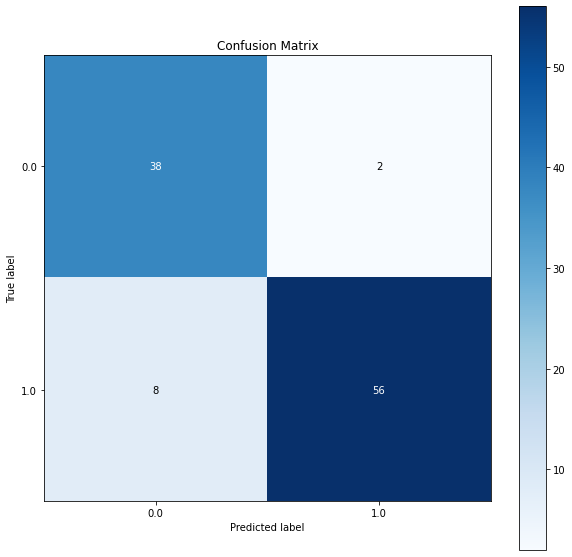

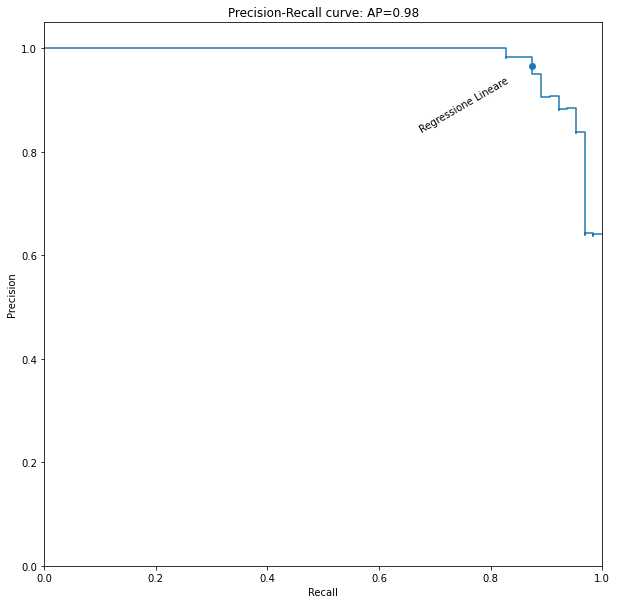

In [10]:
models_metrics = compute_metrics(linreg_CV.best_estimator_, "Regressione Lineare", train, test, target, target_test)

[Torna all'indice](#Costruzione-e-comparazione-di-modelli-per-la-predizione-del-diabete-negli-stadi-iniziali)

## 4.2 Regressione Logistica

Nella regressione logistica la predizione viene effettuata da una funzione lineare che viene successivamente appiattita da un sigmoide.  
I parametri che vengono messi a punto durante la CV sono la tipologia di funzione di regolarizzazione e il parametro di regolarizzazione C.  
La regressione logistica, infatti, tenta di minimizzare la seguente equazione:

\begin{equation*}
- \left[\sum_{e\in E} \left(Y(e)\log{\hat Y(e)} + \left(1 - Y(e)\right)\log{\left(1-\hat Y(e)\right)}\right)\right] + \lambda \cdot regularizer \\
\end{equation*}
dove la prima parte corrisponde alla log loss e la seconda parte, $\lambda$ per funzione di regolarizzazione, serve a diminuire il sovradattamento ai dati.  
Il parametro C corrisponde all'inverso di $\lambda$.
Il parametro penalty corrisponde al tipo di funzione di regolarizzazione:

\begin{align}
L_1 = & \sum_{i=0}^n \vert w_i \vert \\
L_2 = & \sum_{i=0}^n w_i^2 \\
\end{align}


In [11]:
logreg = LogisticRegression(random_state=random_state)
param_grid = {'C' : [.2, .8, 1.6, 2, 8, 10, 16, 30], 'penalty' : ['l1', 'l2', 'none']}
logreg_CV = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=cv_train, verbose=False, n_jobs=-1)
logreg_CV.fit(train, target)
print(logreg_CV.best_params_)

{'C': 10, 'penalty': 'l2'}


In questo caso il modello migliore è quello addestrato con regolarizzatore $L_2$ e $\lambda = 0.1$

,Train accuracy,Test accuracy,Precision,Recall
Regressione Logistica,94.47,93.27,93.85,95.31


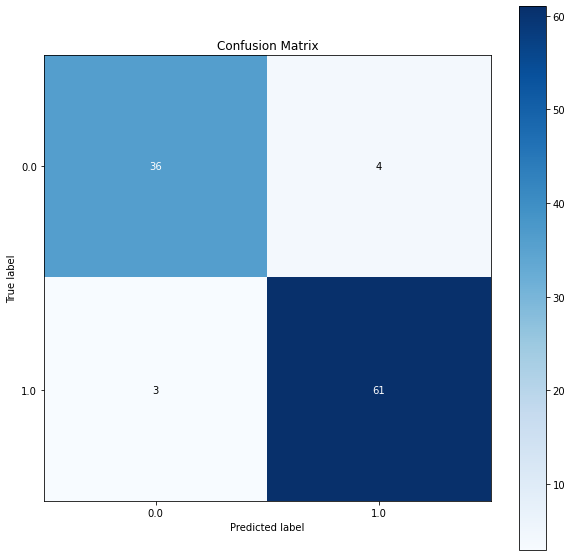

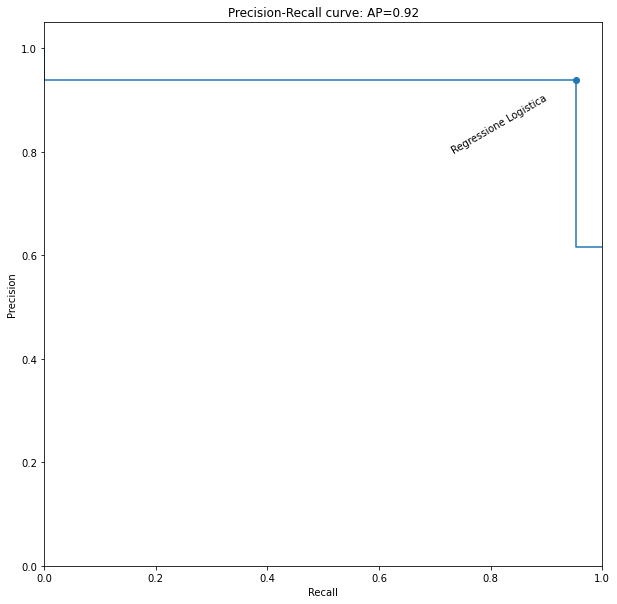

In [12]:
models_metrics = models_metrics.append(compute_metrics(logreg_CV.best_estimator_, "Regressione Logistica", train, test, target, target_test))

[Torna all'indice](#Costruzione-e-comparazione-di-modelli-per-la-predizione-del-diabete-negli-stadi-iniziali)

## 4.3 Albero Decisionale

Un albero decisionale permette la classificazione di un esempio tramite condizioni poste nei suoi nodi interni: partendo dalla radice, ogni condizione viene valutata e si segue il ramo di sinitra o destra in base al risultato (condizione vera o falsa). Arrivando ad un nodo foglia si troverà una stima puntuale della classe.

Gli alberi decisionali possono rappresentare una **qualsiasi** funzione su feature discrete. È quindi indispensabile per evitare l'overfitting potare l'albero prima che la struttura diventi troppo complessa.

Al fine di scegliere i livelli di potatura adeguati, facciamo CV per trovare la struttura ottimale prendendo in considerazione il numero minimo di esempi sulle foglie, perchè un nodo venga suddiviso, e la profondità massima dell'albero.

In [13]:
decision_tree = DecisionTreeClassifier(random_state=random_state)
param_grid = {'min_samples_leaf': [i for i in range(2,10)], 'max_depth': [i for i in range(2,20)]}
decision_tree_CV = GridSearchCV(decision_tree, param_grid=param_grid, cv=cv_train, verbose=False, n_jobs=-1)
decision_tree_CV.fit(train, target)
print(decision_tree_CV.best_params_)

{'max_depth': 6, 'min_samples_leaf': 2}


La migliore struttura trovata corrisponde ad un albero con profondità massima pari a 6 e che non suddividerà ulteriormente se ci sono meno di 2 esempi.

La struttura dell'albero decisionale creato è la seguente:

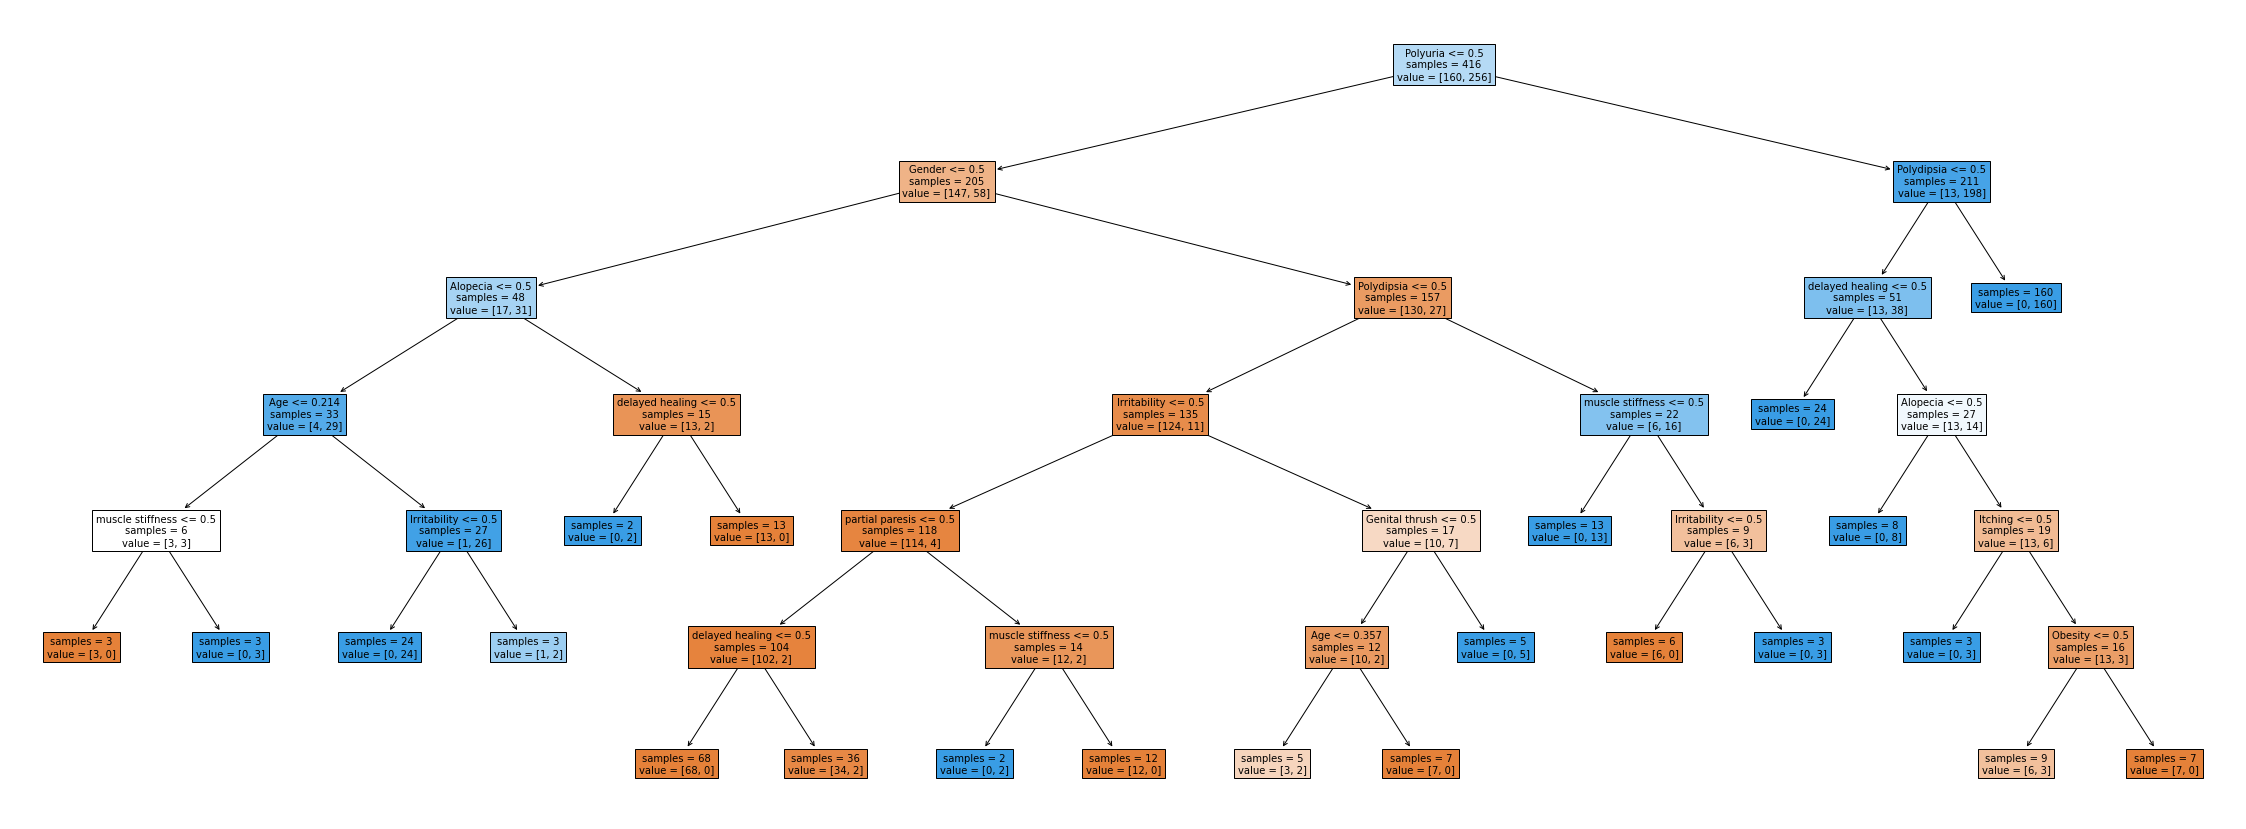

In [14]:
fig, ax = plt.subplots(figsize=(40, 15))
plot_tree(decision_tree_CV.best_estimator_, feature_names=data.columns.values, impurity=False, fontsize=10, filled=True)
fig.savefig('./Output/Albero_Decisionale.png')
plt.show()

[visualizza in grande](./Output/Albero_Decisionale.png)

,Train accuracy,Test accuracy,Precision,Recall
Albero Decisionale,98.08,94.23,96.77,93.75


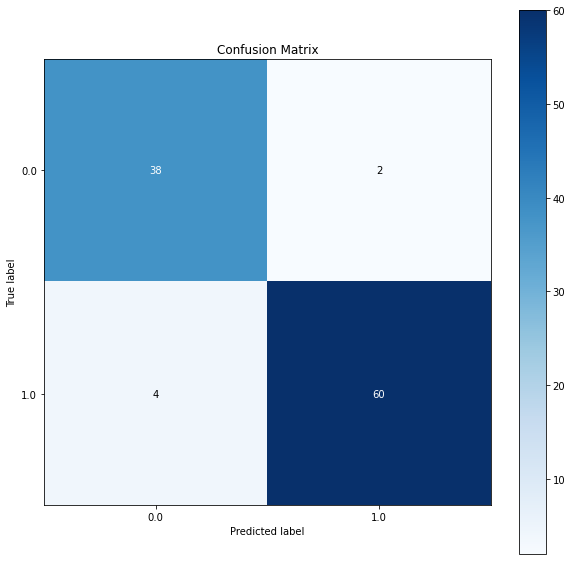

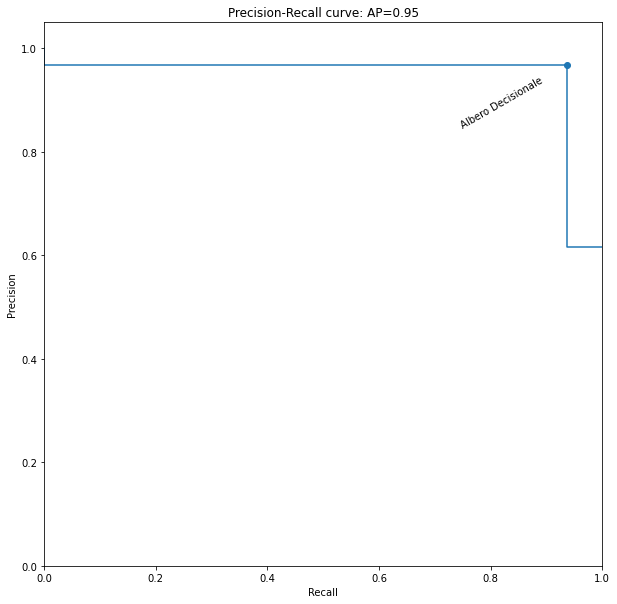

In [15]:
models_metrics = models_metrics.append(compute_metrics(decision_tree_CV.best_estimator_, "Albero Decisionale", train, test, target, target_test))

Per l'albero decisionale, possiamo esaminare quali sono le feature più discriminanti:

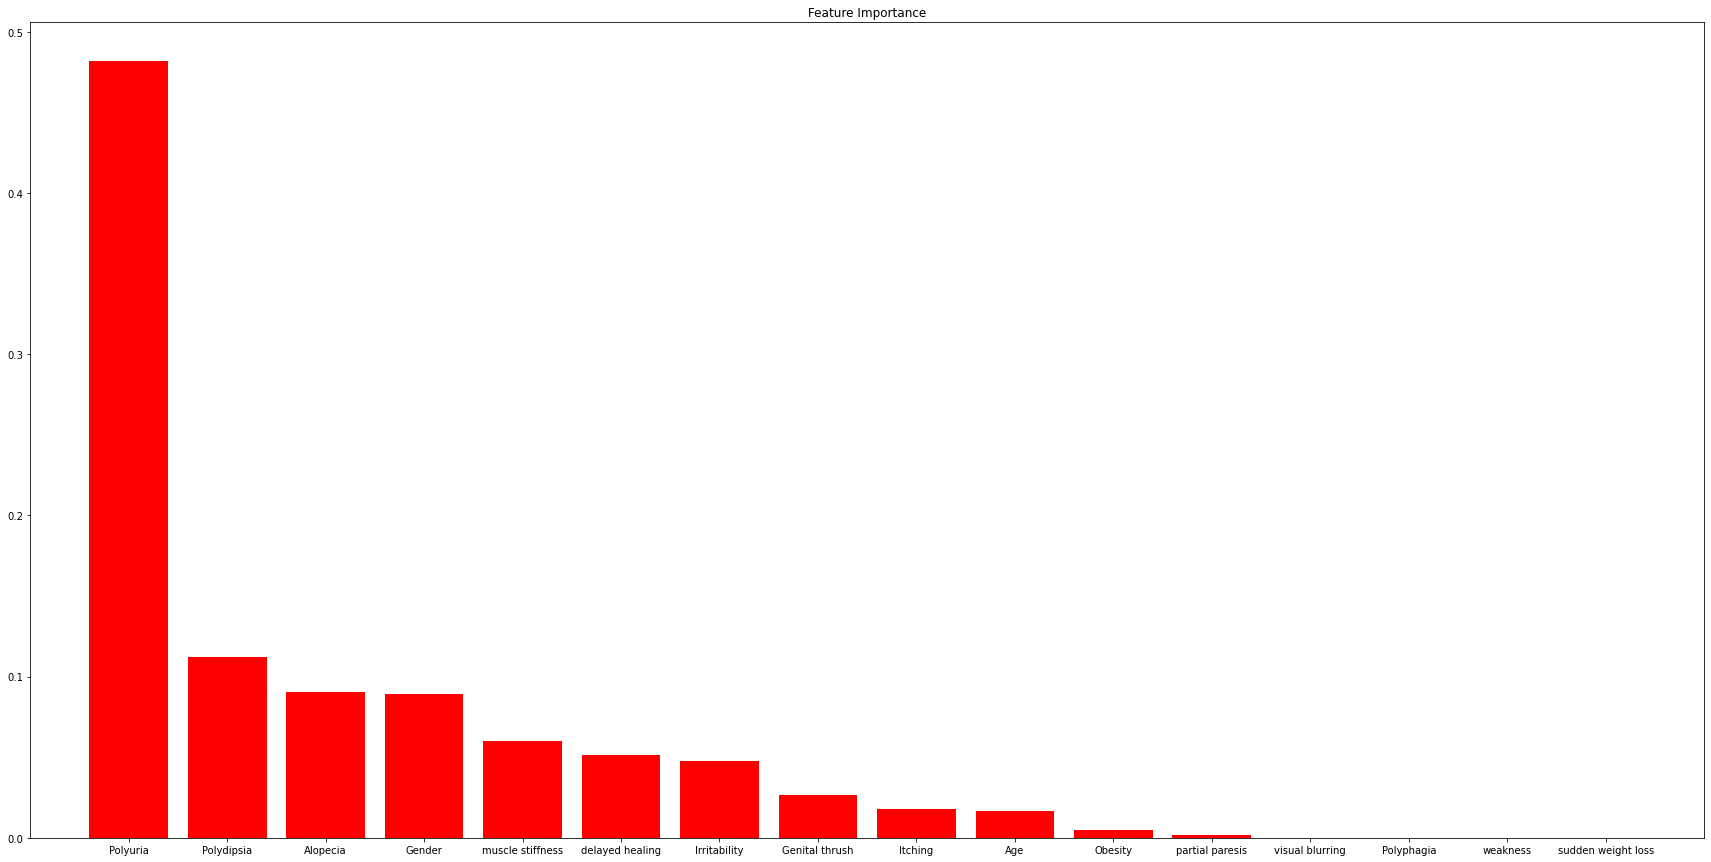

In [16]:
skp.estimators.plot_feature_importances(decision_tree_CV.best_estimator_, feature_names=train.columns.values, figsize=(30,15))
plt.show()

La poliuria è prima, come previsto in quanto presente nella condizione alla radice, è interessante come sia considerata *estremamente* discriminante rispetto alle altre feature.

[Torna all'indice](#Costruzione-e-comparazione-di-modelli-per-la-predizione-del-diabete-negli-stadi-iniziali)

## 4.4 Rete Neurale

Si è considerata per questo progetto lo sviluppo di una semplice rete neurale feed-forward, composta da una gerarchia di funzioni lineari inframmezzate da funzioni di attivazione.

Si è utilizzata la libreria Keras Tuner per trovare la struttura più adeguata al compito tra quelle proposte, ovvero: da 1 a 3 layer nascosti composti da un numero di nodi da 16 a 256 e la funzione di attivazione scelta tra sigmoide, ReLU e tanh.
Infine, un layer composto da un singolo nodo con funzione sigmoidale per collegarsi al layer di output.

In [17]:
class Simple_NN_HM(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
    
    def build(self, hp):
        model = keras.Sequential()
        model.add(keras.Input(shape = self.input_shape))
        units = hp.Int(
            'units',
            min_value=16,
            max_value=256,
            step=8,
            default=64
        )
        activation = hp.Choice(
            'activation',
            values=['relu', 'tanh', 'sigmoid'],
            default='relu'
        )
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(
                keras.layers.Dense(units=units, activation=activation, kernel_initializer=keras.initializers.glorot_uniform(seed=random_state))
            )
        model.add(keras.layers.Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed=random_state)))


        model.compile(
            optimizer=keras.optimizers.SGD(
                hp.Float(
                    'learning_rate',
                    min_value=1e-5,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss = "mean_squared_error",
            metrics = ['accuracy']
        )
        return model

nn_hypermodel = Simple_NN_HM((16,))

Il tuner salva ogni tentativo di addestramento nella cartella da noi indicata in modo da non dover ripetere la ricerca dei parametri (molto costosa) ogni volta che il codice viene eseguito.

In [18]:
tuner = RandomSearch(
    nn_hypermodel,
    objective='val_accuracy',
    seed=random_state,
    max_trials=300,
    executions_per_trial=2,
    directory='Output',
    project_name='NN_tuning_logs'
)

INFO:tensorflow:Reloading Oracle from existing project Output\NN_tuning_logs\oracle.json
INFO:tensorflow:Reloading Tuner from Output\NN_tuning_logs\tuner0.json


Il training set è stato suddiviso in training e validation set in quanto Keras non supporta il K-Fold CV.  
Viene usata una suddivisione 4 a 1.

Successivamente viene ricercata la miglior struttura, allenando ogni tentativo per 200 epoche.

In [19]:
class ClearTrainingOutput(keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

nn_train, nn_validation, nn_train_target, nn_validation_target = train_test_split(train, target, test_size=0.2, random_state=random_state)
tuner.search(nn_train, nn_train_target, epochs = 200, validation_data = (nn_validation, nn_validation_target), callbacks = [ClearTrainingOutput()], verbose = 0)

INFO:tensorflow:Oracle triggered exit


In [20]:
best_hps = tuner.get_best_hyperparameters()[0]



print(f"""
La ricerca degli parametri è terminata.
Il numero di ottimale di layer completi lineari è {best_hps.get('num_layers')}.
Il numero ottimale di nodi nei layer completi lineari è {best_hps.get('units')}.
La funzione di attivazione ottimale è di tipo {best_hps.get('activation')}
Infine, il passo η ottimale è {best_hps.get('learning_rate')}.
""")



La ricerca degli parametri è terminata.
Il numero di ottimale di layer completi lineari è 3.
Il numero ottimale di nodi nei layer completi lineari è 200.
La funzione di attivazione ottimale è di tipo relu
Infine, il passo η ottimale è 0.005478794870972872.



Il modello è quindi il seguente:

In [21]:
display(tuner.hypermodel.build(best_hps).summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
dense (Dense)                (None, 200)               3400
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201
Total params: 84,001
Trainable params: 84,001
Non-trainable params: 0
_________________________________________________________________


None

![Modello Neural Network](./Output/nn_model.png)

Per la rete neurale è possibile visualizzare le curve di apprendimento:

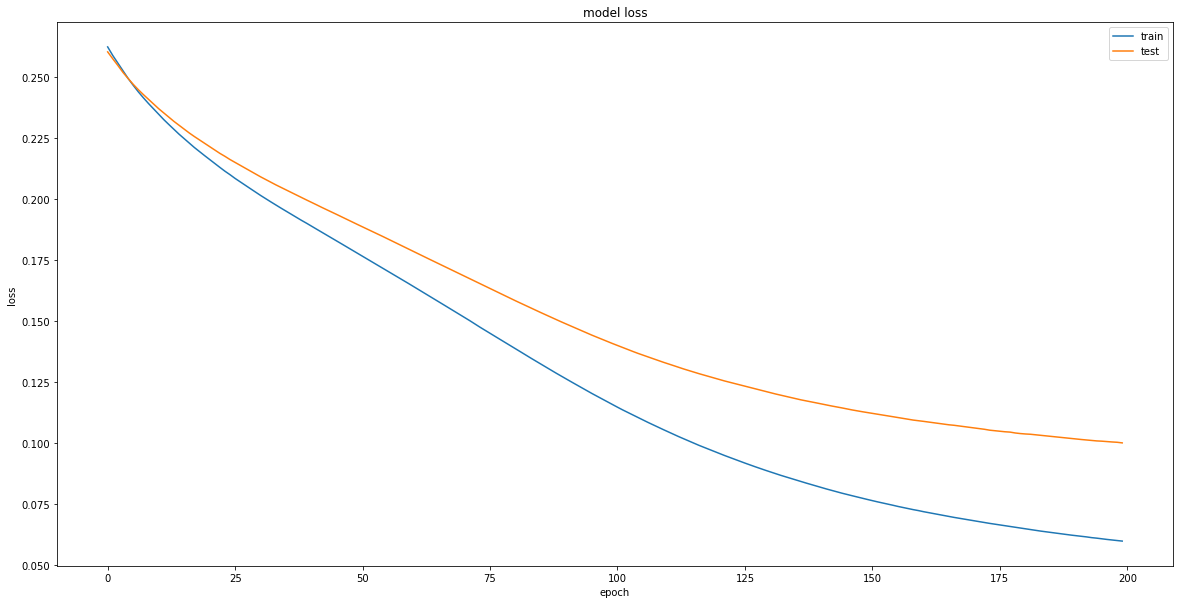

In [22]:
nn_model = tuner.hypermodel.build(best_hps)
history = nn_model.fit(nn_train, nn_train_target, epochs = 200, validation_data = (nn_validation, nn_validation_target), verbose=0)

# Costruzione del grafico per la loss

plt.subplots(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

La curva di apprendimento sembra adeguata, non mostrando overfitting.

,Train accuracy,Test accuracy,Precision,Recall
Rete Neurale,92.55,92.31,95.16,92.19


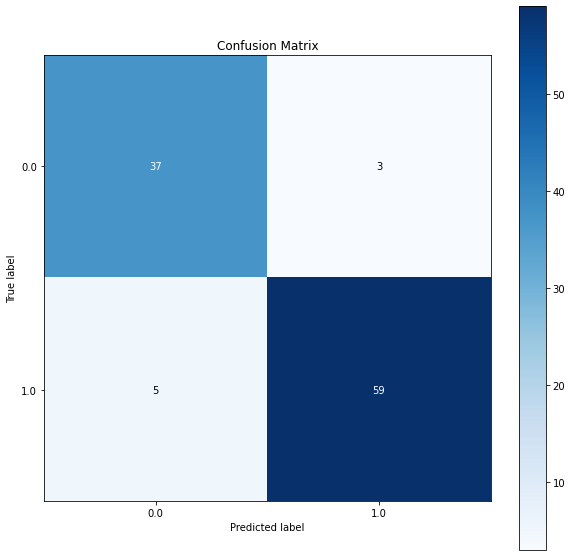

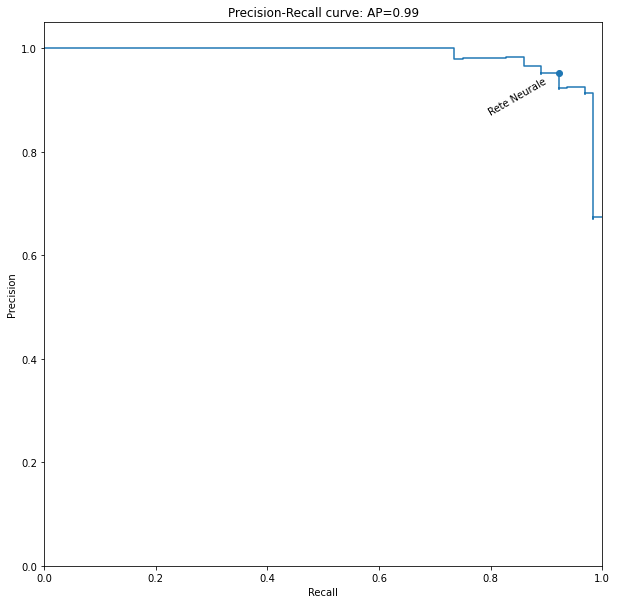

In [23]:
models_metrics = models_metrics.append(compute_metrics(nn_model, "Rete Neurale", train, test, target, target_test))

[Torna all'indice](#Costruzione-e-comparazione-di-modelli-per-la-predizione-del-diabete-negli-stadi-iniziali)

## 4.5 Support Vector Machine

La support vector machine è un classificatore basato su kernel.
I kernel sono funzioni che producono nuove feature a partire da quelle di input per creare un nuovo spazio di feature (embedding space).
La SVM costruisce un'iperpiano che divide esempi positivi da negativi all'interno dello spazio di embedding.

I kernel supportati dalla libreria usata sono lineare, polinomiale, radial basis function e sigmoidale.  
Il parametro degree regola il grado della funzione nel kernel polinomiale.
C corrisponde all'inverso di $\lambda$, il parametro di regolarizzazione.

In [24]:
svm = SVC(probability=True, random_state=random_state)
svm_CV = GridSearchCV(svm, param_grid={'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': [2, 3], 'C' : [.2, .4, .8, 1, 1.5, 1.6, 1.8, 2, 4, 8, 10], 'gamma':['auto','scale']}, 
                      cv=cv_train, verbose=False)
svm_CV.fit(train, target)
print(svm_CV.best_params_)

{'C': 8, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


Il miglior modello utilizza un kernel di radial basis function, $\exp(-\gamma\lVert x-x'\rVert^2)$, con $\gamma = \frac{1}{n_{features}*Varianza(X)}$ e regolarizzazione (non settabile) di tipo $L_2$ con $\lambda = 0.125$

,Train accuracy,Test accuracy,Precision,Recall
Support Vector Machine,99.52,95.19,95.38,96.88


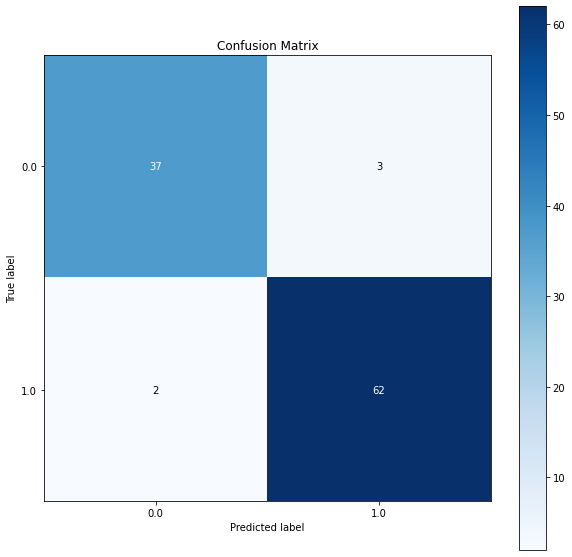

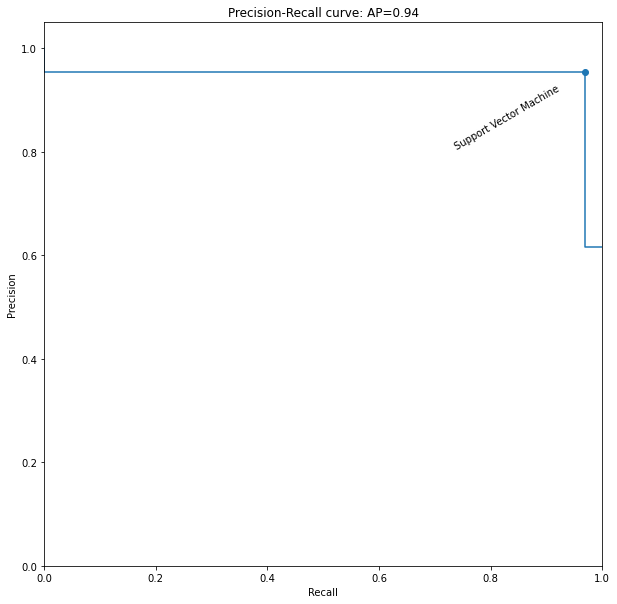

In [25]:
models_metrics = models_metrics.append(compute_metrics(svm_CV.best_estimator_, "Support Vector Machine", train, test, target, target_test))

[Torna all'indice](#Costruzione-e-comparazione-di-modelli-per-la-predizione-del-diabete-negli-stadi-iniziali)

## 4.6 Random Forest

La random forest è una tipologia di ensemble learning dove un certo numero di alberi viene addestrato sul dataset utilizzando un sottoinsieme di feature diverse. La categorizzazione avviene tramite votazione da parte dell'insieme di alberi.

I parametri che vengono affinati tramite CV sono gli stessi per gli alberi decisionali a cui viene aggiunto il numero di alberi presenti nella foresta.

In [26]:
random_forest = RandomForestClassifier(random_state=random_state)
param_grid = {'n_estimators': [30, 40, 50, 60], 'min_samples_leaf': [12, 13, 14, 15], 'max_depth': [3, 4, 5, 6], 'bootstrap': [True, False]}
random_forest_CV = GridSearchCV(estimator=random_forest, param_grid=param_grid, 
                             cv=cv_train, verbose=False, n_jobs=-1)
random_forest_CV.fit(train, target)
print(random_forest_CV.best_params_)

{'bootstrap': False, 'max_depth': 5, 'min_samples_leaf': 12, 'n_estimators': 50}


La random forest migliore è composta da 50 alberi con una profondità massima di 5 e un numero di esempi alle foglie di 12.  
Il parametro bootstrap si riferisce all'utilizzo di una porzione del dataset (True) o all'intero dataset (False) per l'allenamento di ogni singolo albero.  
Si noti come la potatura degli alberi nella Random Forest è molto più massiccia che nell'albero decisionale: questo perchè gli alberi di una random forest sono dei cosiddetti *weak learner* che non devono rappresentare la funzione di classificazione da soli, ma nel loro insieme.

,Train accuracy,Test accuracy,Precision,Recall
Random Forest,94.95,93.27,93.85,95.31


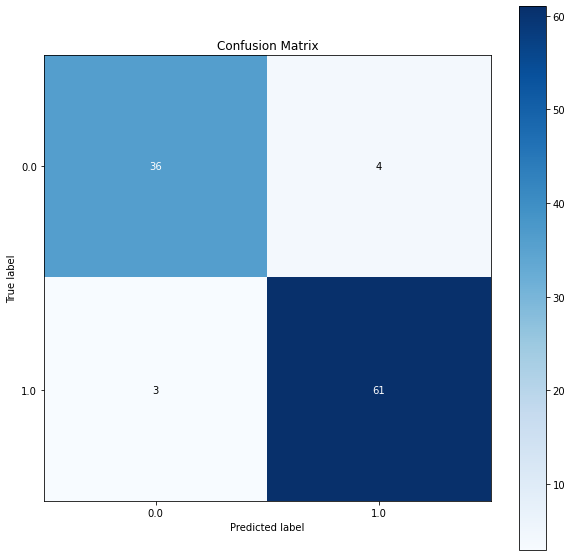

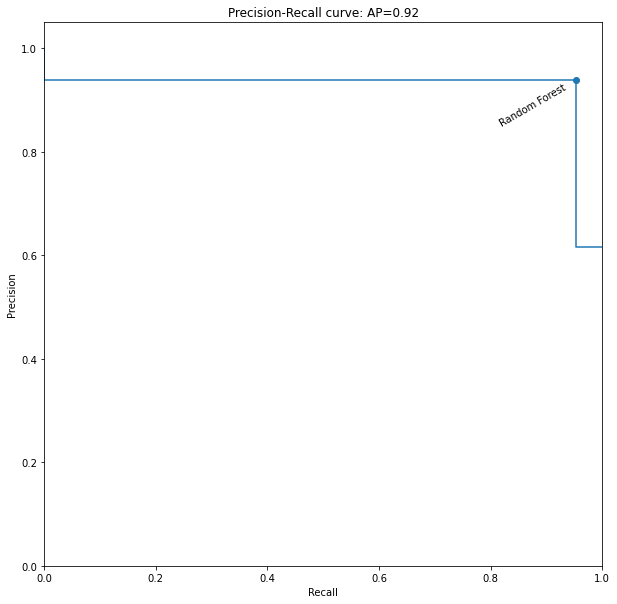

In [27]:
models_metrics = models_metrics.append(compute_metrics(random_forest_CV.best_estimator_, "Random Forest", train, test, target, target_test))

Anche per la random forest è possibile visualizzare il grafico della feature importance.

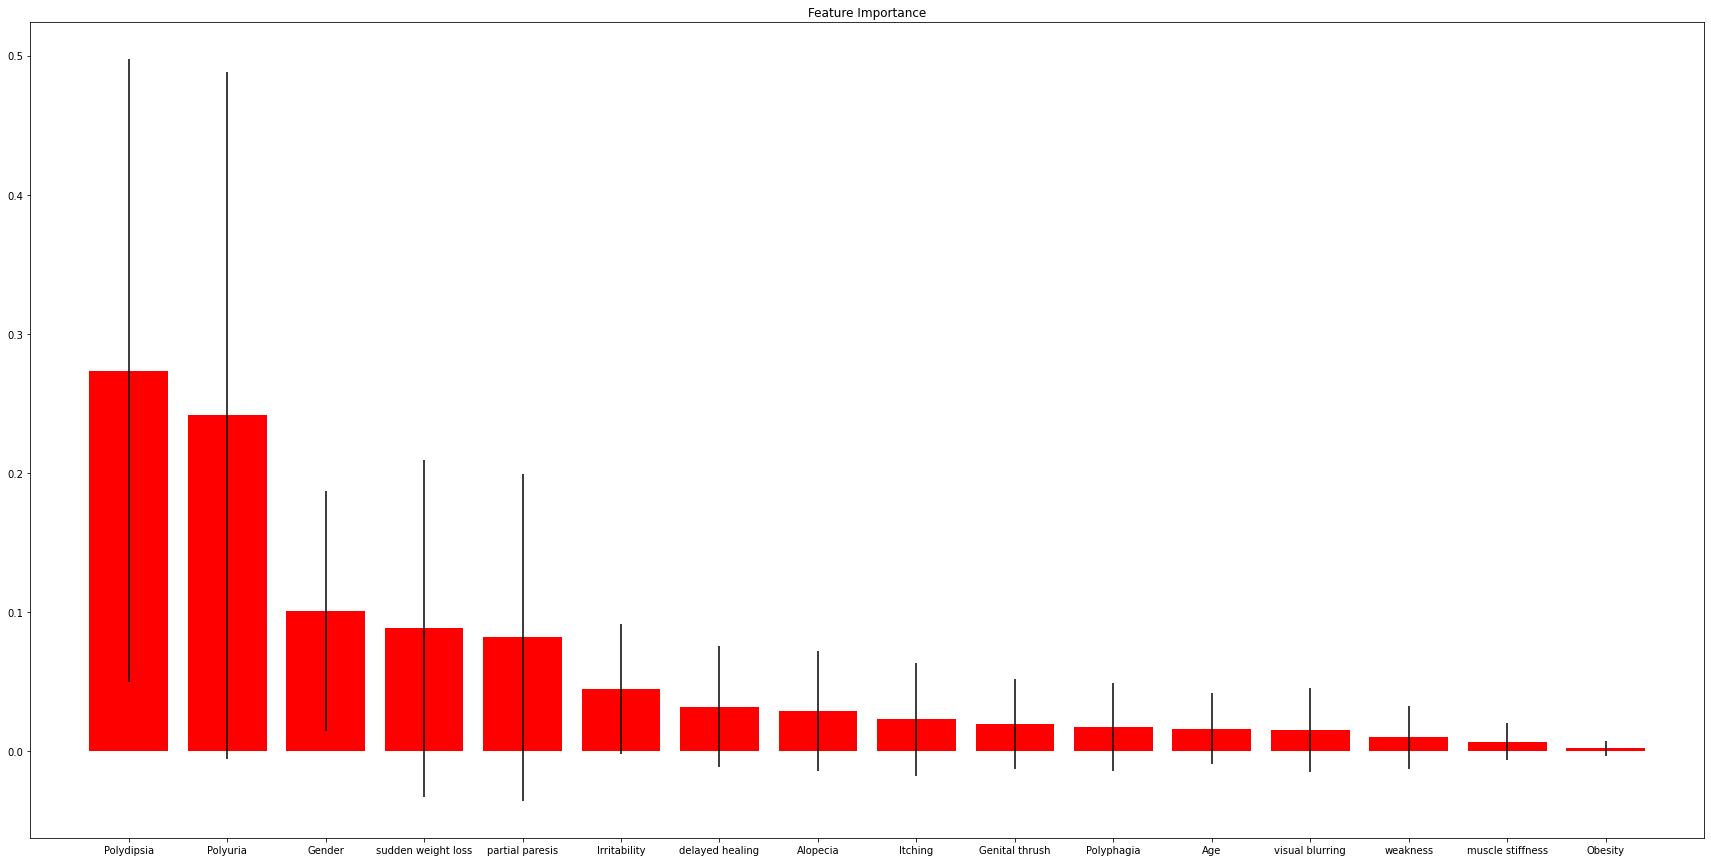

In [28]:
skp.estimators.plot_feature_importances(random_forest_CV.best_estimator_, feature_names=train.columns.values, figsize=(30,15))
plt.show()

Anche qui la poliuria è tra le feature più discriminanti ma, a causa della scelta casuale di feature utilizzate da ogni albero all'interno della foresta, non sovrasta tutte le altre feature, e anzi viene superata dalla Polidipsia. Essendo i due fenomeni collegati non stupisce che possano essere altrettanto significanti presi singolarmente, ma non insieme.

[Torna all'indice](#Costruzione-e-comparazione-di-modelli-per-la-predizione-del-diabete-negli-stadi-iniziali)

## 4.7 ADAptive BOOSTing

L'ADAptive BOOSTing è un modello di ensemble learning dove un certo numero di *weak learners* viene addestrato in serie, ognuno dando più o meno peso ai vari esempi a seconda del fatto che essi siano stati incorrettamente classificati o meno.

I parametri messi a punto nel corso della CV sono il numero di *weak learners* e il tasso di apprendimento di ogni *weak learner*.

In [29]:
Ada_Boost = AdaBoostClassifier(random_state=random_state)
param_grid={'learning_rate' : [0.09, 0.095, 0.1, 0.102, 0.105], 'n_estimators': [40, 50, 60, 70, 80]}
Ada_Boost_CV = GridSearchCV(estimator=Ada_Boost, param_grid=param_grid, cv=cv_train, verbose=False)
Ada_Boost_CV.fit(train, target)
print(Ada_Boost_CV.best_params_)

{'learning_rate': 0.095, 'n_estimators': 70}


Il learning rate ottimale è leggermente più basso di quello di default, il numero di *weak learners* nel modello ottimale è 70.

,Train accuracy,Test accuracy,Precision,Recall
ADAptive BOOSTing,89.9,92.31,91.18,96.88


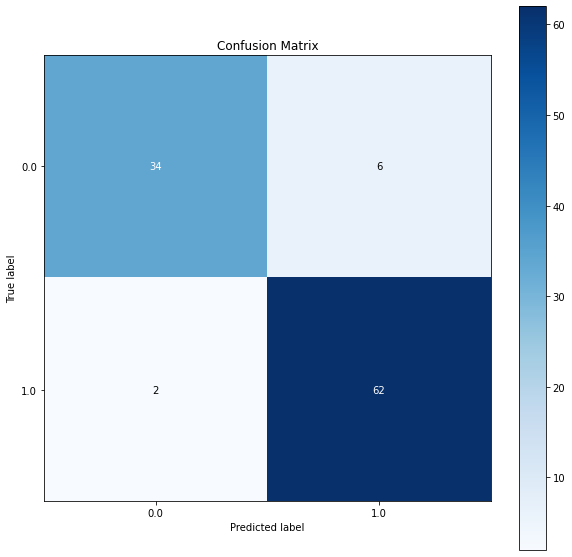

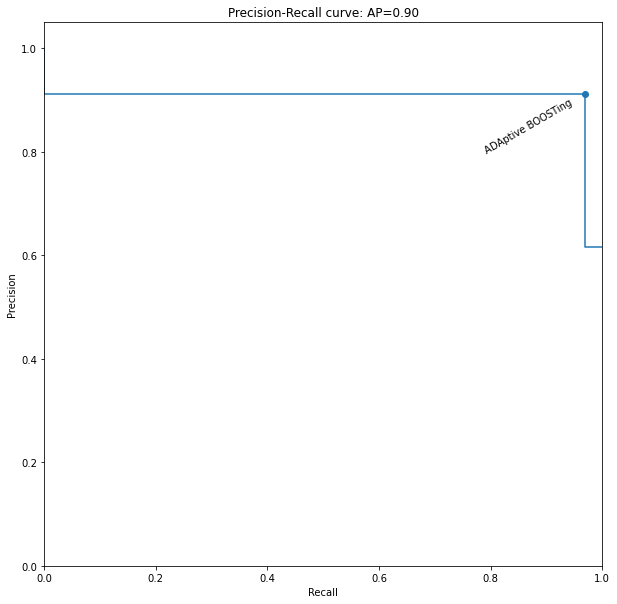

In [30]:
models_metrics = models_metrics.append(compute_metrics(Ada_Boost_CV.best_estimator_, "ADAptive BOOSTing", train, test, target, target_test))

È possibile visualizzare il grafico della feature importance anche per l'ADAptive BOOSTing

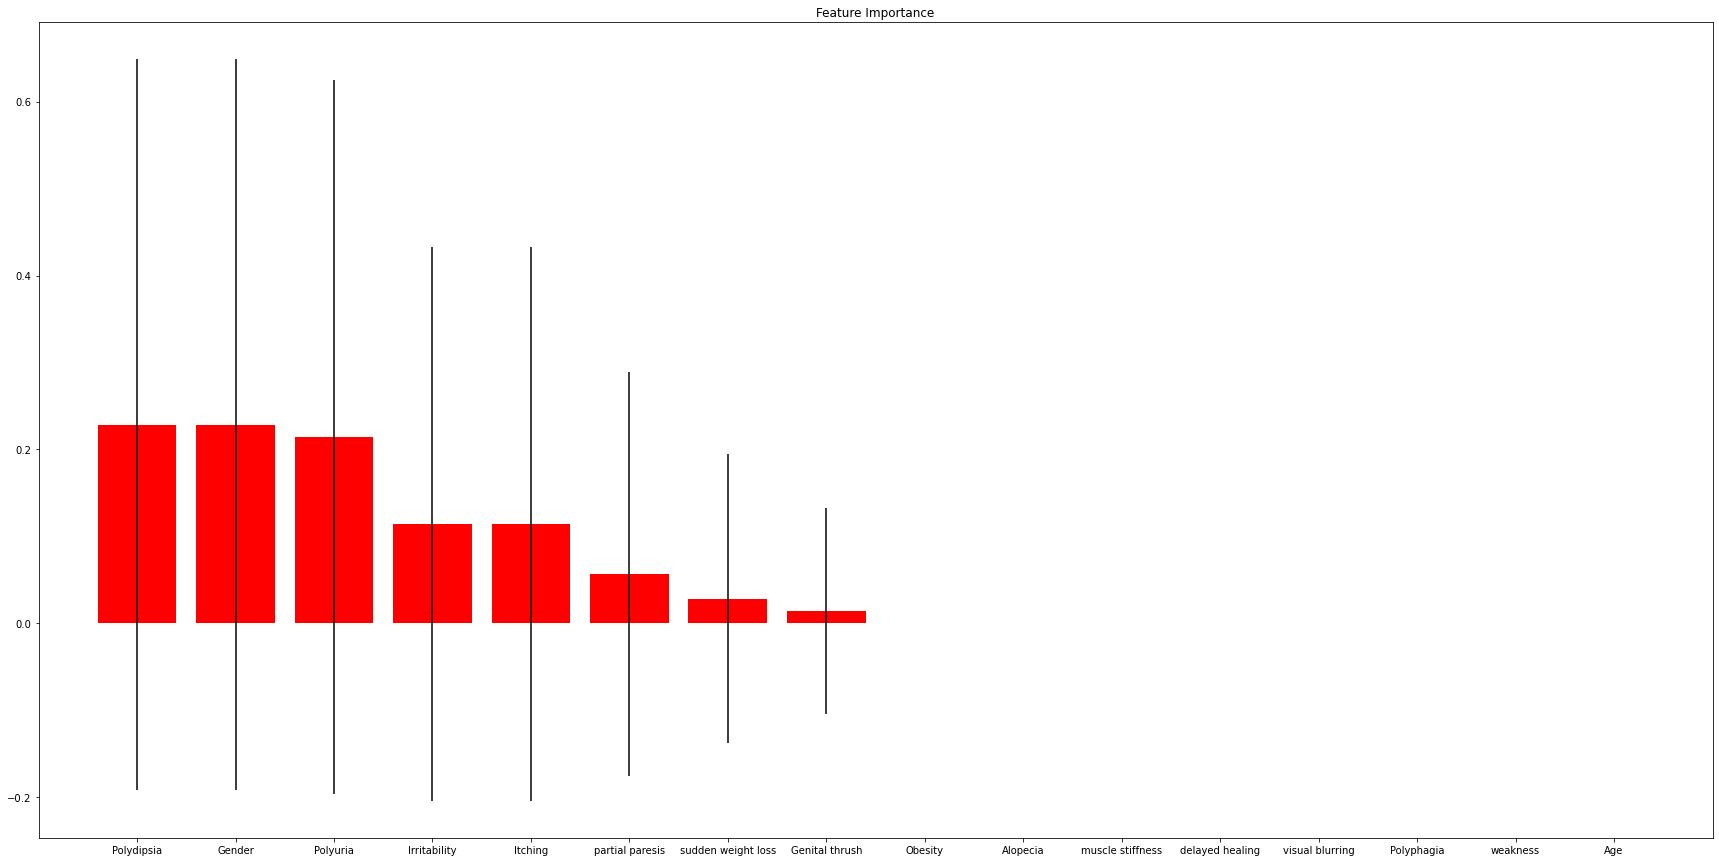

In [31]:
skp.estimators.plot_feature_importances(Ada_Boost_CV.best_estimator_, feature_names=train.columns.values, figsize=(30,15))
plt.show()

La parte più interessante di questo grafico è la presenza di parecchie feature senza importanza.
Si sono formulate due ipotesi: che quelle feature non sono efficaci nel discriminare i casi più difficili, e quindi più importanti per l'algoritmo di Adaptive Boosting, e che i weak learner utilizzati dalla libreria per l'ADAptive BOOSTing utilizzano un numero limitato di feature.

[Torna all'indice](#Costruzione-e-comparazione-di-modelli-per-la-predizione-del-diabete-negli-stadi-iniziali)

## 4.8 K-Nearest Neighbors

K-NN è un esempio di Case-Based Reasoning, dove ogni caso viene classificato in base a K esempi più vicini (più simili) ad esso.

Il parametro da ottimizzare in questo caso è, ovviamente, il K.

In [32]:
knn = KNeighborsClassifier()
knn_CV = GridSearchCV(estimator=knn, param_grid={'n_neighbors': range(2, 7)}, 
                      cv=cv_train, verbose=False).fit(train, target)
print(knn_CV.best_params_)

{'n_neighbors': 3}


Il K ottimale sembra essere 3.

,Train accuracy,Test accuracy,Precision,Recall
K-Nearest Neighbors,98.8,94.23,100.0,90.62


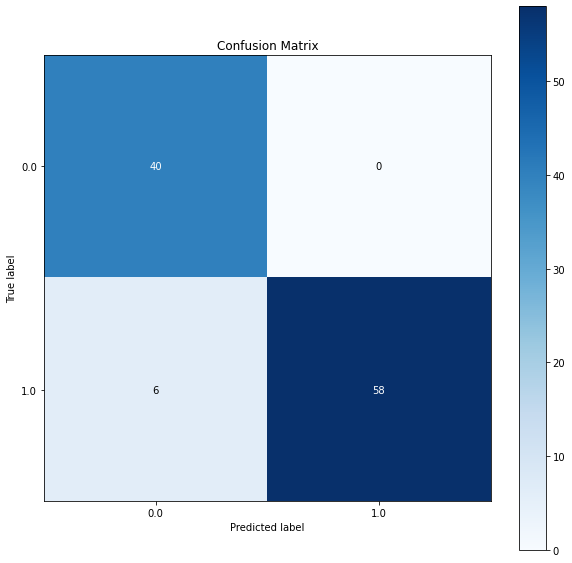

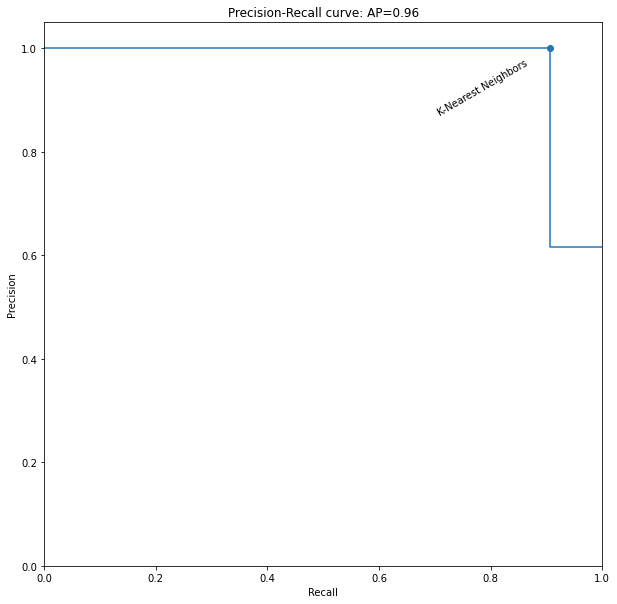

In [33]:
models_metrics = models_metrics.append(compute_metrics(knn_CV.best_estimator_, "K-Nearest Neighbors", train, test, target, target_test))

[Torna all'indice](#Costruzione-e-comparazione-di-modelli-per-la-predizione-del-diabete-negli-stadi-iniziali)

## 4.9 Naive Bayes

Modello basato sull'apprendimento Bayesiano: si calcola la probabilità che un nuovo esempio appartenga ad una determinata classe avendo come evidenza le feature del modello e l'insieme degli esempi di training.

Il parametro ottimizzato tramite CV è uno pseudo-conteggio da aggiungere al numero di casi osservati, in modo da regolarizzare il modello.

In [34]:
naive_bayes = MultinomialNB()
param_grid = {'alpha':[0, 1, 10, 50, 100]}
naive_bayes_CV = GridSearchCV(estimator=naive_bayes, param_grid=param_grid, cv=cv_train, verbose=False)
naive_bayes_CV.fit(train, target)
print(naive_bayes_CV.best_params_)

{'alpha': 10}


Lo pseudo conteggio aggiungerà 10 esempi per classe.

,Train accuracy,Test accuracy,Precision,Recall
Naive Bayes,91.35,88.46,88.24,93.75


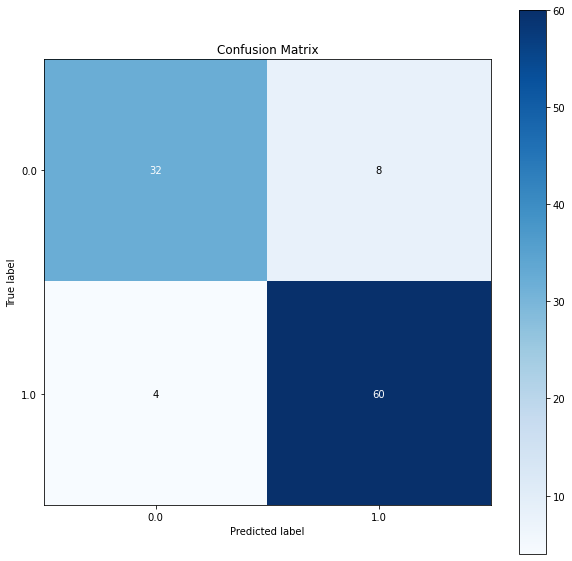

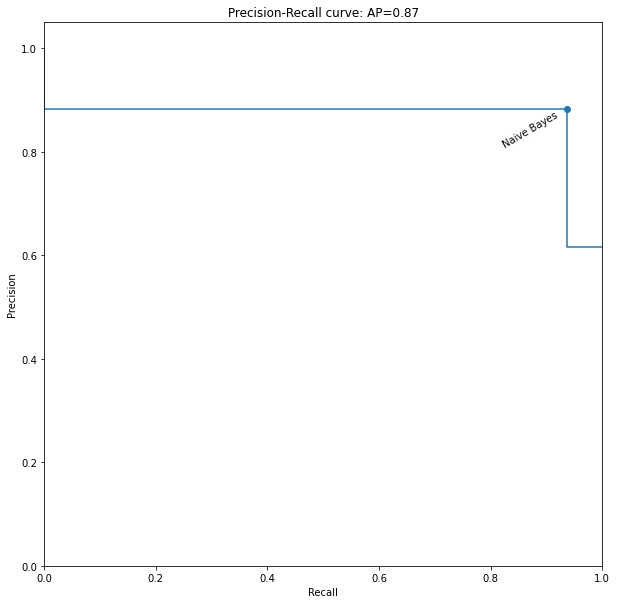

In [35]:
models_metrics = models_metrics.append(compute_metrics(naive_bayes_CV.best_estimator_, "Naive Bayes", train, test, target, target_test))

[Torna all'indice](#Costruzione-e-comparazione-di-modelli-per-la-predizione-del-diabete-negli-stadi-iniziali)

## 5. Conclusione

Si analizzano ora i risultati ottenuti.  
Vengono innanzitutto mostrati i modelli, ordinati per accuratezza sul test set.

In [36]:
models_metrics[["Train accuracy", "Test accuracy", "Precision", "Recall"]].sort_values(by=['Test accuracy', 'Precision', 'Recall'], ascending=[False,False,False])

,Train accuracy,Test accuracy,Precision,Recall
Support Vector Machine,99.52,95.19,95.38,96.88
K-Nearest Neighbors,98.80,94.23,100.00,90.62
Albero Decisionale,98.08,94.23,96.77,93.75
Regressione Logistica,94.47,93.27,93.85,95.31
Random Forest,94.95,93.27,93.85,95.31
Rete Neurale,92.55,92.31,95.16,92.19
ADAptive BOOSTing,89.90,92.31,91.18,96.88
Regressione Lineare,92.79,90.38,96.55,87.50
Naive Bayes,91.35,88.46,88.24,93.75


Sembra che non ci sia overfitting sui vari modelli. La differenza fra l'accuratezza sul training set e sul test set può essere considerata sospetta nel caso della SVM e K-NN, tuttavia si considerano i modelli comunque validi in quanto riescono *in ogni caso* a generalizzare molto bene, al punto da essere fra i migliori modelli tra quelli qui proposti.  

L'accuratezza comunque non è solitamente la metrica più adatta nella decisione di un modello.  
Precisione e richiamo tendono a rispecchiare esigenze reali in maniera più diretta.

Un modello ad alta precisione minimizza il numero di falsi positivi, evitando per esempio esami o interventi invasivi non necessari.

In [37]:
models_metrics[["Train accuracy", "Test accuracy", "Precision", "Recall"]].sort_values(by=['Precision', 'Recall', 'Test accuracy'], ascending=[False, False, False])

,Train accuracy,Test accuracy,Precision,Recall
K-Nearest Neighbors,98.80,94.23,100.00,90.62
Albero Decisionale,98.08,94.23,96.77,93.75
Regressione Lineare,92.79,90.38,96.55,87.50
Support Vector Machine,99.52,95.19,95.38,96.88
Rete Neurale,92.55,92.31,95.16,92.19
Regressione Logistica,94.47,93.27,93.85,95.31
Random Forest,94.95,93.27,93.85,95.31
ADAptive BOOSTing,89.90,92.31,91.18,96.88
Naive Bayes,91.35,88.46,88.24,93.75


In tal caso, il K-NN sarebbe il modello più adatto a predire l'insorgenza del diabete.

Tuttavia ciò non è il caso, in quanto gli esami per il diabete, per quanto lunghi e fastidiosi, non sono invasivi.
È quindi preferibile prescrivere dei test in più piuttosto che lasciare un paziente malato senza cure.

Per questo servono modelli ad alto richiamo, che quindi minimizzano il numero di falsi negativi, ovvero di malati non individuati dal modello.

In [38]:
models_metrics[["Train accuracy", "Test accuracy", "Precision", "Recall"]].sort_values(by=['Recall', 'Precision', 'Test accuracy'], ascending=[False, False, False])

,Train accuracy,Test accuracy,Precision,Recall
Support Vector Machine,99.52,95.19,95.38,96.88
ADAptive BOOSTing,89.90,92.31,91.18,96.88
Regressione Logistica,94.47,93.27,93.85,95.31
Random Forest,94.95,93.27,93.85,95.31
Albero Decisionale,98.08,94.23,96.77,93.75
Naive Bayes,91.35,88.46,88.24,93.75
Rete Neurale,92.55,92.31,95.16,92.19
K-Nearest Neighbors,98.80,94.23,100.00,90.62
Regressione Lineare,92.79,90.38,96.55,87.50


Si consiglia quindi come modello la SVM, il modello a recall più alto non sacrificando troppo la precisione.

Si mostrano il grafo di precisione-richiamo e le curve di precisione-richiamo dei vari modelli, a riassumere le performance degli stessi:

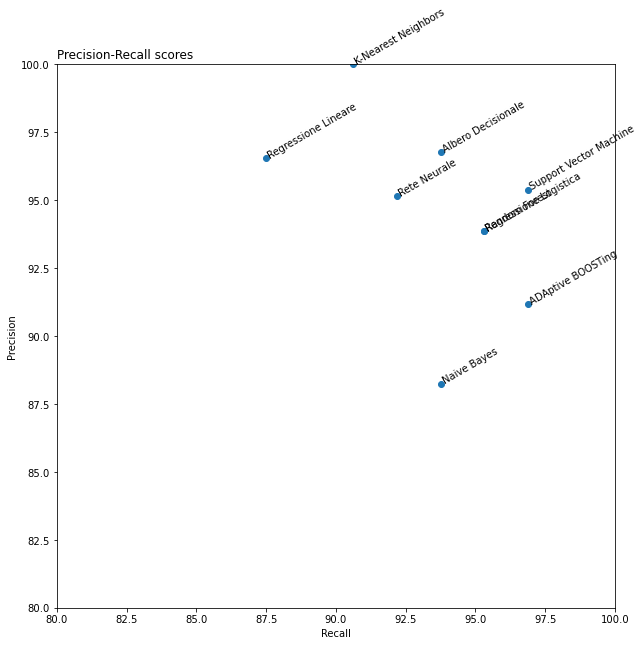

In [39]:
plt.figure(figsize=(10,10))

plt.scatter(models_metrics['Recall'], models_metrics['Precision'])

for model_name in models_metrics.index.values:
    plt.annotate(model_name, (models_metrics['Recall'][model_name], models_metrics['Precision'][model_name]), rotation=30)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([80, 100])
plt.xlim([80, 100])
plt.title('Precision-Recall scores', loc='left')
plt.show()

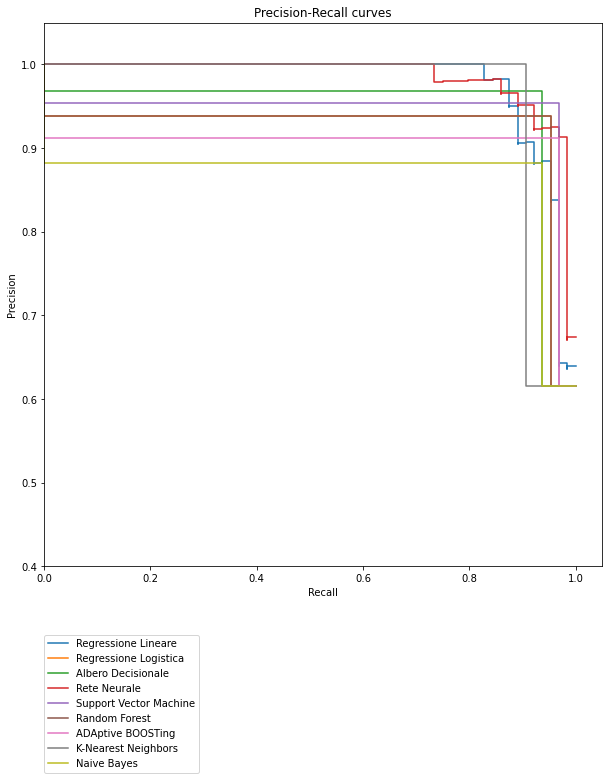

In [40]:
plt.figure(figsize=(10,10))
for model_name in models_metrics.index.values:
    plt.step(models_metrics['Recall curve'][model_name], models_metrics['Precision curve'][model_name], where='post', label=model_name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.4, 1.05])
plt.xlim([0.0, 1.05])
plt.title('Precision-Recall curves')
plt.legend(loc=(0, -.38))
plt.show()

Salviamo il miglior modello assieme allo scaler per un uso futuro:


In [41]:
with open(os.path.join(os.path.curdir,"Output","model.pickle"),"wb") as f:
    pickle.dump({'scaler':scaler, 'model':svm_CV.best_estimator_}, f)

e infine costruiamo l'albero di decisione come simbolo di funzione in linguaggio Prolog, in modo che possa essere utilizzato in un sistema di ragionamento con logica del primo ordine.

In [42]:
def build_tree(tree, node, labels):
    if tree.children_left[node] == tree.children_right[node]:
        return ["leaf({:.2g})".format((tree.value[node][0][1]/(tree.value[node][0][1] + tree.value[node][0][0])))]
    else:
        answer = ["bt("]
        if labels[tree.feature[node]] == 'Gender':
            answer.append("gender_male")
        elif labels[tree.feature[node]] == 'Age':
            answer.append("age_over{}".format(int(round(scaler.inverse_transform([[0 if i else tree.threshold[node] for i in range(17)]])[0][0]))))
        else:
            answer.append(labels[tree.feature[node]].replace(' ','_').lower())
        answer.append(", ")
        answer.extend(build_tree(tree, tree.children_left[node], labels))
        answer.append(", ")
        answer.extend(build_tree(tree, tree.children_right[node], labels))
        answer.append(")")
        return answer

"".join(build_tree(decision_tree_CV.best_estimator_.tree_, 0, train.columns))

'bt(polyuria, bt(gender_male, bt(alopecia, bt(age_over35, bt(muscle_stiffness, leaf(0), leaf(1)), bt(irritability, leaf(1), leaf(0.67))), bt(delayed_healing, leaf(1), leaf(0))), bt(polydipsia, bt(irritability, bt(partial_paresis, bt(delayed_healing, leaf(0), leaf(0.056)), bt(muscle_stiffness, leaf(1), leaf(0))), bt(genital_thrush, bt(age_over45, leaf(0.4), leaf(0)), leaf(1))), bt(muscle_stiffness, leaf(1), bt(irritability, leaf(0), leaf(1))))), bt(polydipsia, bt(delayed_healing, leaf(1), bt(alopecia, leaf(1), bt(itching, leaf(1), bt(obesity, leaf(0.33), leaf(0))))), leaf(1)))'

Ed una versione dell'albero etichettata con la probabilità che la condizione per utilizzarla nella versione probabilistica.

In [43]:
def build_tree_prob(tree, node, labels):
    if tree.children_left[node] == tree.children_right[node]:
        return ["leaf({:.2g})".format((tree.value[node][0][1]/(tree.value[node][0][1] + tree.value[node][0][0])))]
    else:
        answer = ["bt("]
        if labels[tree.feature[node]] == 'Gender':
            answer.append("gender_male")
        elif labels[tree.feature[node]] == 'Age':
            answer.append("age_over{}".format(int(round(scaler.inverse_transform([[0 if i else tree.threshold[node] for i in range(17)]])[0][0]))))
        else:
            answer.append(labels[tree.feature[node]].replace(' ','_').lower())
        answer.append(", {:.2g}, ".format(tree.n_node_samples[tree.children_right[node]]/tree.n_node_samples[node]))
        answer.extend(build_tree_prob(tree, tree.children_left[node], labels))
        answer.append(", ")
        answer.extend(build_tree_prob(tree, tree.children_right[node], labels))
        answer.append(")")
        return answer

"".join(build_tree_prob(decision_tree_CV.best_estimator_.tree_,0,train.columns))

'bt(polyuria, 0.51, bt(gender_male, 0.77, bt(alopecia, 0.31, bt(age_over35, 0.82, bt(muscle_stiffness, 0.5, leaf(0), leaf(1)), bt(irritability, 0.11, leaf(1), leaf(0.67))), bt(delayed_healing, 0.87, leaf(1), leaf(0))), bt(polydipsia, 0.14, bt(irritability, 0.13, bt(partial_paresis, 0.12, bt(delayed_healing, 0.35, leaf(0), leaf(0.056)), bt(muscle_stiffness, 0.86, leaf(1), leaf(0))), bt(genital_thrush, 0.29, bt(age_over45, 0.58, leaf(0.4), leaf(0)), leaf(1))), bt(muscle_stiffness, 0.41, leaf(1), bt(irritability, 0.33, leaf(0), leaf(1))))), bt(polydipsia, 0.76, bt(delayed_healing, 0.53, leaf(1), bt(alopecia, 0.7, leaf(1), bt(itching, 0.84, leaf(1), bt(obesity, 0.44, leaf(0.33), leaf(0))))), leaf(1)))'

[Torna all'indice](#Costruzione-e-comparazione-di-modelli-per-la-predizione-del-diabete-negli-stadi-iniziali)